In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
vix_data = yf.download('^VIX', start='2019-01-01', end='2024-11-01', interval='1d')
vix=vix_data['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [6]:
# Setting the frequency of the data
vix = vix.asfreq('D').ffill()  # forward fill to handle missing values

In [8]:
# Initial data preview
print(vix.head())

Ticker                          ^VIX
Date                                
2019-01-02 00:00:00+00:00  23.219999
2019-01-03 00:00:00+00:00  25.450001
2019-01-04 00:00:00+00:00  21.379999
2019-01-05 00:00:00+00:00  21.379999
2019-01-06 00:00:00+00:00  21.379999


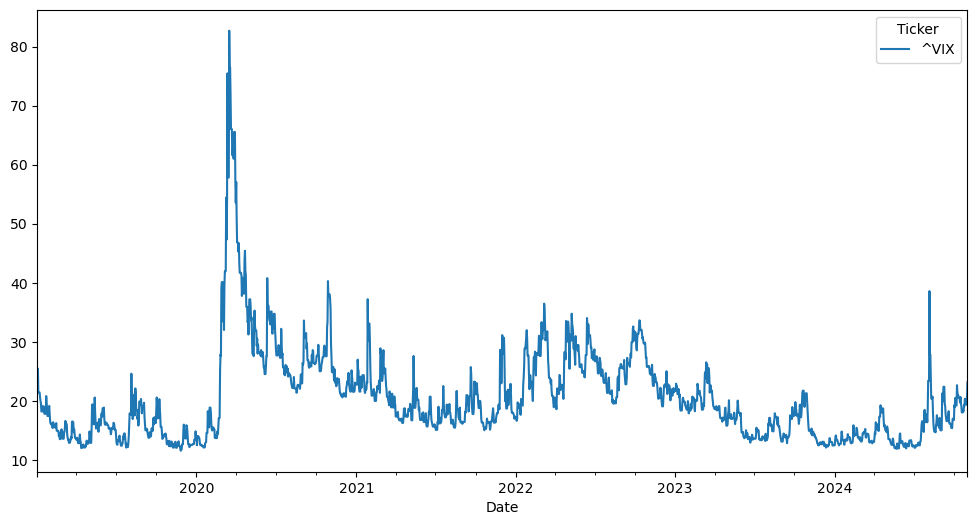

In [10]:
# Plotting the data
vix.plot(figsize=(12, 6))
plt.show()

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

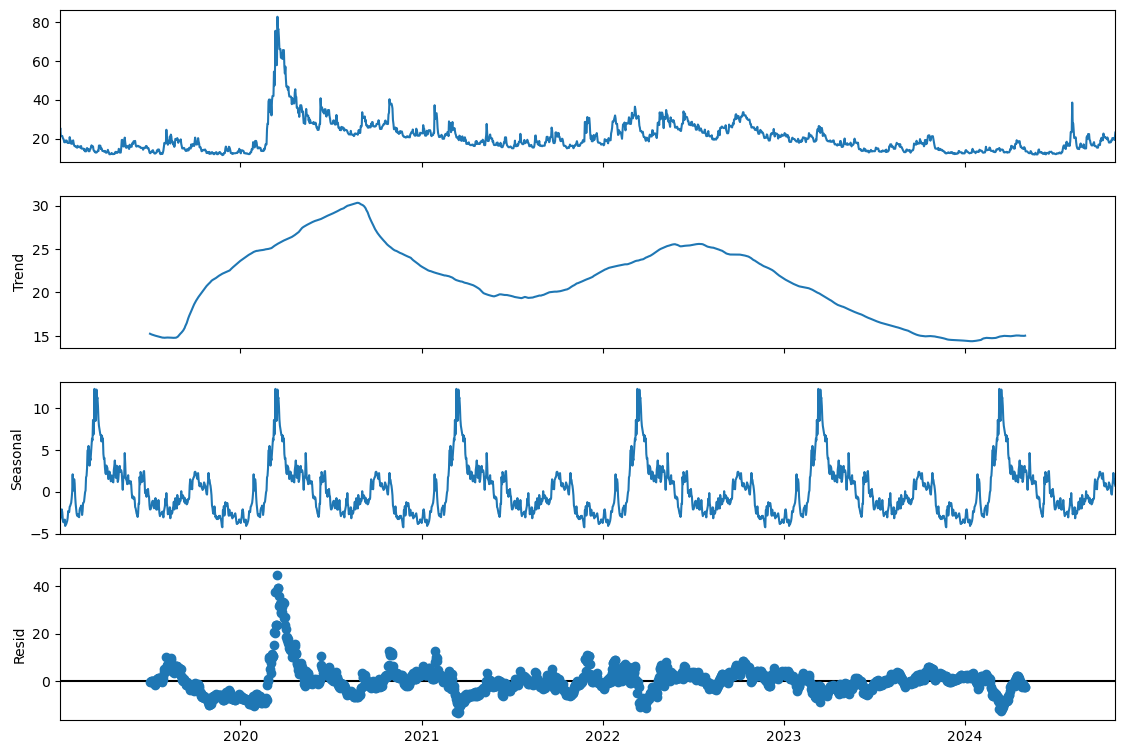

In [14]:
# Decomposing the time series
results = seasonal_decompose(vix, model='additive', period=365)  # assuming yearly seasonality
fig = results.plot()

# Adjust the size of the plots
fig.set_size_inches(12, 8)
plt.show()

In [16]:
len(vix)

2130

In [18]:
train = vix.iloc[:1712]
test = vix.iloc[1712:]

In [20]:
#preprocess data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [22]:
#print first and last 5 values
vix.head(), vix.tail()

(Ticker                          ^VIX
 Date                                
 2019-01-02 00:00:00+00:00  23.219999
 2019-01-03 00:00:00+00:00  25.450001
 2019-01-04 00:00:00+00:00  21.379999
 2019-01-05 00:00:00+00:00  21.379999
 2019-01-06 00:00:00+00:00  21.379999,
 Ticker                          ^VIX
 Date                                
 2024-10-27 00:00:00+00:00  20.330000
 2024-10-28 00:00:00+00:00  19.799999
 2024-10-29 00:00:00+00:00  19.340000
 2024-10-30 00:00:00+00:00  20.350000
 2024-10-31 00:00:00+00:00  23.160000)

In [24]:
#convert data into scale of 0 to 1
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [26]:
scaled_train[:10]

array([[0.16416021],
       [0.19550246],
       [0.13829935],
       [0.13829935],
       [0.13829935],
       [0.13858045],
       [0.12550947],
       [0.11862262],
       [0.11187631],
       [0.09346452]])

In [32]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [36]:
# Assuming scaled_train is previously defined and properly scaled dataset
n_input = 12  # Number of lag observations as input (window length)
n_features = 1  # Number of features per step (often 1 for univariate time series)

# Define generator
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [38]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.16416021 0.19550246 0.13829935 0.13829935 0.13829935 0.13858045
 0.12550947 0.11862262 0.11187631 0.09346452 0.09346452 0.09346452]
Predict this y: 
 [[0.10583274]]


In [40]:
X.shape

(1, 12, 1)

In [42]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [44]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [46]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1700/1700 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0029
Epoch 2/50
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0012
Epoch 3/50
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0011
Epoch 4/50
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0012
Epoch 5/50
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 9.0394e-04
Epoch 6/50
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7.2535e-04
Epoch 7/50
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7.3074e-04
Epoch 8/50
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6.6991e-04
Epoch 9/50
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7.4207e-04
Epoch 10/50
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 5.8913e-04
Epoch 11/50
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7.1672e-04
Epoch 12/50
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6.8159e-04
Epoch 13/50
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7.8211e-04
Epoch 14/50
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6.7605e-04


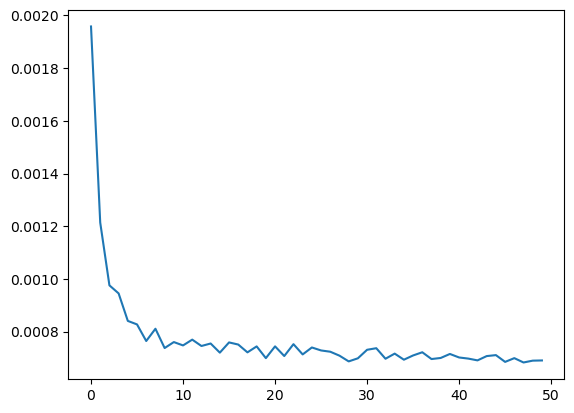

In [50]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [52]:
last_train_batch = scaled_train[-12:]

In [54]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [56]:
model.predict(last_train_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


array([[0.03513514]], dtype=float32)

In [58]:
scaled_test[0]

array([0.03232607])

In [60]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [62]:
test_predictions

[array([0.03513514], dtype=float32),
 array([0.0378882], dtype=float32),
 array([0.04040988], dtype=float32),
 array([0.04270543], dtype=float32),
 array([0.04483143], dtype=float32),
 array([0.04683314], dtype=float32),
 array([0.04873349], dtype=float32),
 array([0.05053023], dtype=float32),
 array([0.05224493], dtype=float32),
 array([0.05388152], dtype=float32),
 array([0.05544371], dtype=float32),
 array([0.05692891], dtype=float32),
 array([0.05833786], dtype=float32),
 array([0.05967683], dtype=float32),
 array([0.06094962], dtype=float32),
 array([0.06215976], dtype=float32),
 array([0.06331046], dtype=float32),
 array([0.0644047], dtype=float32),
 array([0.06544527], dtype=float32),
 array([0.06643486], dtype=float32),
 array([0.06737606], dtype=float32),
 array([0.06827124], dtype=float32),
 array([0.06912272], dtype=float32),
 array([0.06993264], dtype=float32),
 array([0.07070309], dtype=float32),
 array([0.07143602], dtype=float32),
 array([0.0721333], dtype=float32),
 arr

In [64]:
test.head()

Ticker,^VIX
Date,
2023-09-10 00:00:00+00:00,13.84
2023-09-11 00:00:00+00:00,13.80
2023-09-12 00:00:00+00:00,14.23
2023-09-13 00:00:00+00:00,13.48
2023-09-14 00:00:00+00:00,12.82


In [66]:
true_predictions = scaler.inverse_transform(test_predictions)

In [68]:
test['Predictions'] = true_predictions

/var/folders/p7/gwhw97kd1rdg70ntnf_trfcm0000gp/T/ipykernel_41425/4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<Axes: xlabel='Date'>

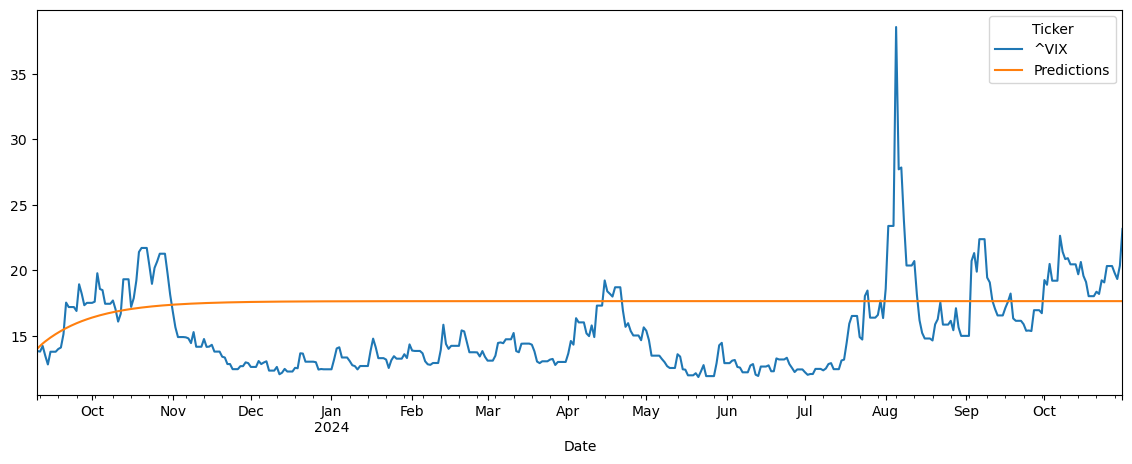

In [70]:
test.plot(figsize=(14,5))

In [80]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['^VIX'],test['Predictions']))
print(rmse)

3.8662434152789413
